In [2]:
# ARMA estimation and forcast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics

import warnings                               
warnings.filterwarnings('ignore')

<b> Model Estimation and Forecasting </b>

First let's use some examples to read the model estimation result and see how the forecast is done for ARMA model.

**Example: ARMA(1,1)**

In [3]:
#use a simulated ARMA data
ar = np.array([1, -0.5])
ma = np.array([1,0.2])
ARMA_object = ArmaProcess(ar, ma)
simulated_data = ARMA_object.generate_sample(nsample=1000)

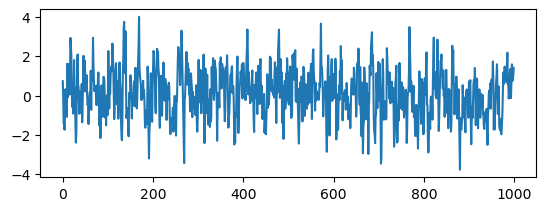

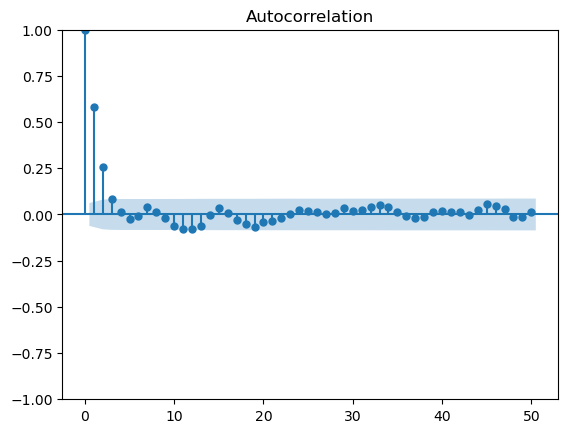

In [4]:
plt.subplot(2,1,1)

plt.plot(simulated_data)
plt.show()

plot_acf(simulated_data,lags=50)
plt.show()

In [5]:
#looks stationary, let's fit an ARMA(1,1) model to this data

model = ARIMA(simulated_data, order=(1,0,1))

In [6]:
# check the summary table

results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1398.102
Date:                Tue, 07 Nov 2023   AIC                           2804.205
Time:                        13:37:23   BIC                           2823.836
Sample:                             0   HQIC                          2811.666
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1145      0.068      1.674      0.094      -0.020       0.248
ar.L1          0.4630      0.047      9.948      0.000       0.372       0.554
ma.L1          0.1841      0.052      3.561      0.0

The estimated model is $X_t+0.0437=0.5127(X_{t-1}+0.0437)+0.1740Z_{t-1}$\\

If we use this mdoel to get in-sample estimations *manually*: 

In [7]:
# collect fitted parameters
fit_c = results.params[0] 
fit_ar1 = results.arparams[0] 
fit_ma1 = results.maparams[0]

#make predictions for last 10 time steps
n=10
y= simulated_data
y_hat_manual = (y[-n-1:-1]-fit_c)*fit_ar1 + results.resid[-n-1:-1]*fit_ma1 + fit_c

In [8]:
y_hat_manual

array([ 0.15326499,  0.6097799 ,  0.81912286,  0.43569176, -0.10446843,
        0.47948956,  0.99779642,  0.82610415,  0.40283755,  0.61823089])

In [9]:
#or use predict function
y_hat = results.predict(start=-n)

In [10]:
y_hat #same

array([ 0.15326499,  0.6097799 ,  0.81912286,  0.43569176, -0.10446843,
        0.47948956,  0.99779642,  0.82610415,  0.40283755,  0.61823089])

We can also use this model to do out-of-sample forecast:

In [11]:
results.predict(start=1000, end=1010)

array([0.84997347, 0.45496422, 0.27209422, 0.18743435, 0.14824096,
       0.13009633, 0.12169626, 0.11780743, 0.1160071 , 0.11517363,
       0.11478778])

In [12]:
#or use forecast function
results.forecast(10)

array([0.84997347, 0.45496422, 0.27209422, 0.18743435, 0.14824096,
       0.13009633, 0.12169626, 0.11780743, 0.1160071 , 0.11517363])

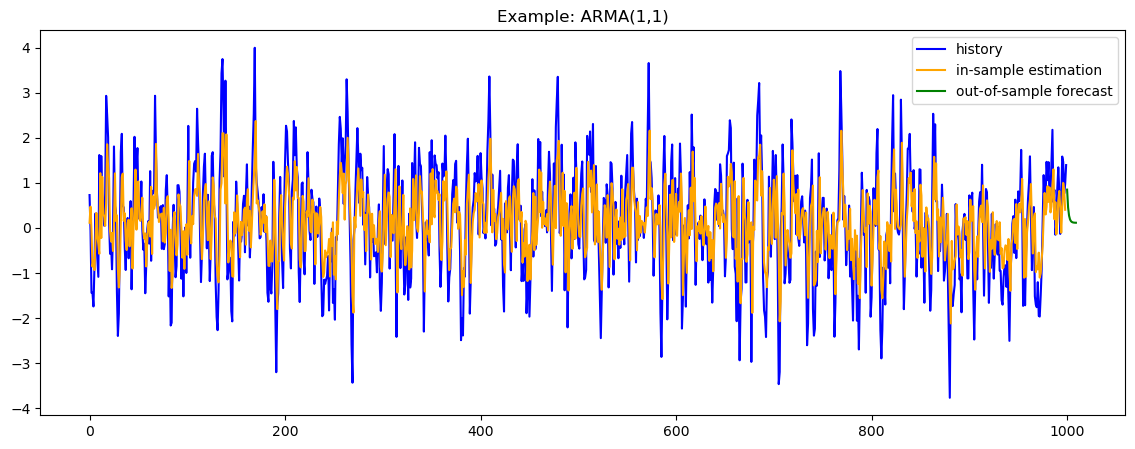

In [13]:
# visualize the data and predictions
history =  pd.DataFrame(simulated_data)

pred = results.predict(start=0, end=1010)
prediction = pd.DataFrame(pred)
estimation = prediction[0:999]
forecast = prediction[1000:1010]

history.columns =['x']
estimation.columns =['x']
forecast.columns =['x']

pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
history.plot(kind='line',y='x',color='blue', label='history', ax=ax)
estimation.plot(kind='line',y='x',color='orange', label='in-sample estimation', ax=ax)
forecast.plot(kind='line',y='x',color='green', label='out-of-sample forecast', ax=ax)
plt.title('Example: ARMA(1,1)')
plt.show()

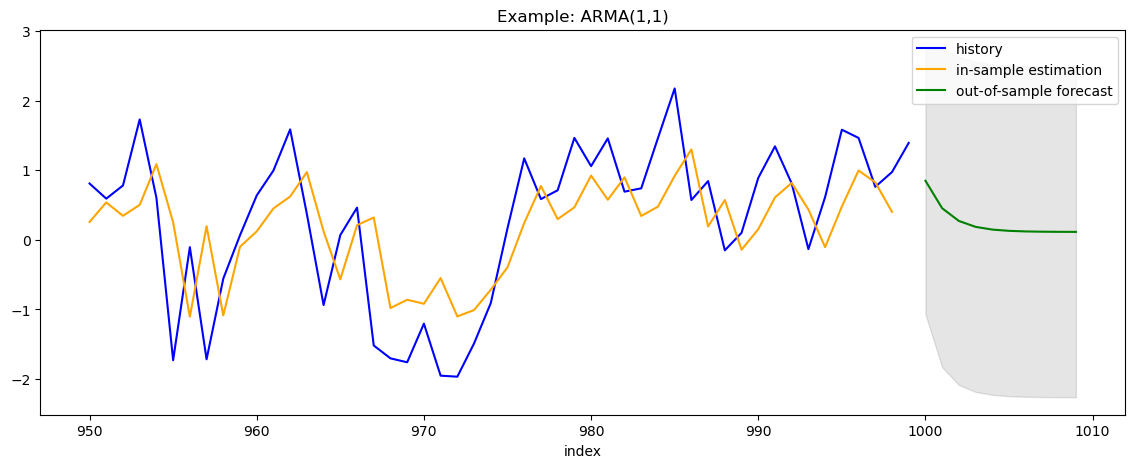

In [14]:
#zoom in and add confidence interval

history_new = history[950:1000]
estimation_new = estimation[950:1000]
forecast = results.get_forecast(10).summary_frame()
forecast['index']=range(1000,1010,1)

pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
history_new.plot(kind='line',y='x',color='blue', label='history', ax=ax)
estimation_new.plot(kind='line',y='x',color='orange', label='in-sample estimation', ax=ax)
forecast.plot(kind='line',x='index',y='mean',color='green', label='out-of-sample forecast', ax=ax)
ax.fill_between(forecast['index'], forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Example: ARMA(1,1)')
plt.show()

<b> Example: MA(4) </b>

In [15]:
ar = np.array([1])
ma = np.array([1, -0.8, 0.7, -0.7, 0.5])
MA_object = ArmaProcess(ar, ma)
simulated_data_2 =  MA_object.generate_sample(nsample=500)

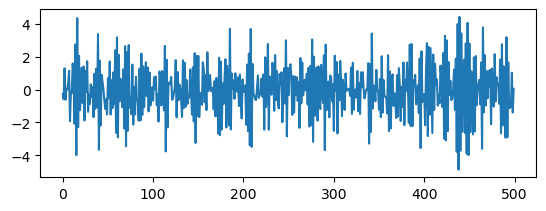

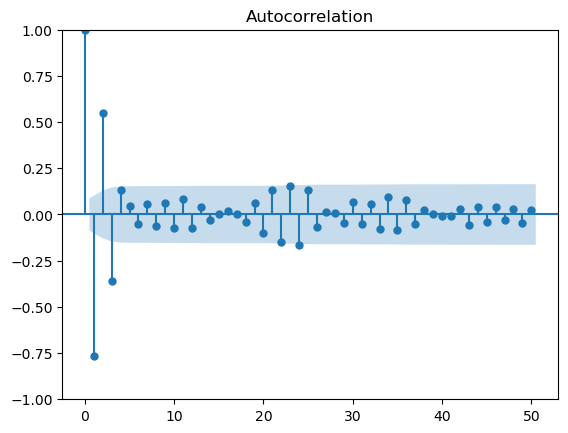

In [16]:
plt.subplot(2,1,1)

plt.plot(simulated_data_2)
plt.show()

plot_acf(simulated_data_2,lags=50)
plt.show()

In [17]:
model_2 = ARIMA(simulated_data_2, order=(0,0,4))
results = model_2.fit()

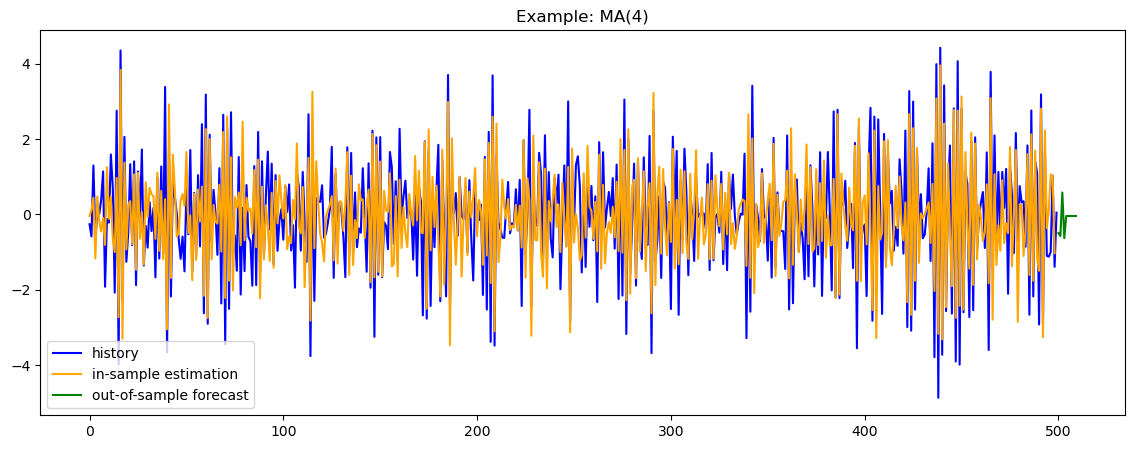

In [18]:
# visualize the data and predictions
history =  pd.DataFrame(simulated_data_2)

pred = results.predict(start=0, end=510)
prediction = pd.DataFrame(pred)
estimation = prediction[0:499]
forecast = prediction[500:510]

history.columns =['x']
estimation.columns =['x']
forecast.columns =['x']

pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
history.plot(kind='line',y='x',color='blue', label='history', ax=ax)
estimation.plot(kind='line',y='x',color='orange', label='in-sample estimation', ax=ax)
forecast.plot(kind='line',y='x',color='green', label='out-of-sample forecast', ax=ax)
plt.title('Example: MA(4)')
plt.show()

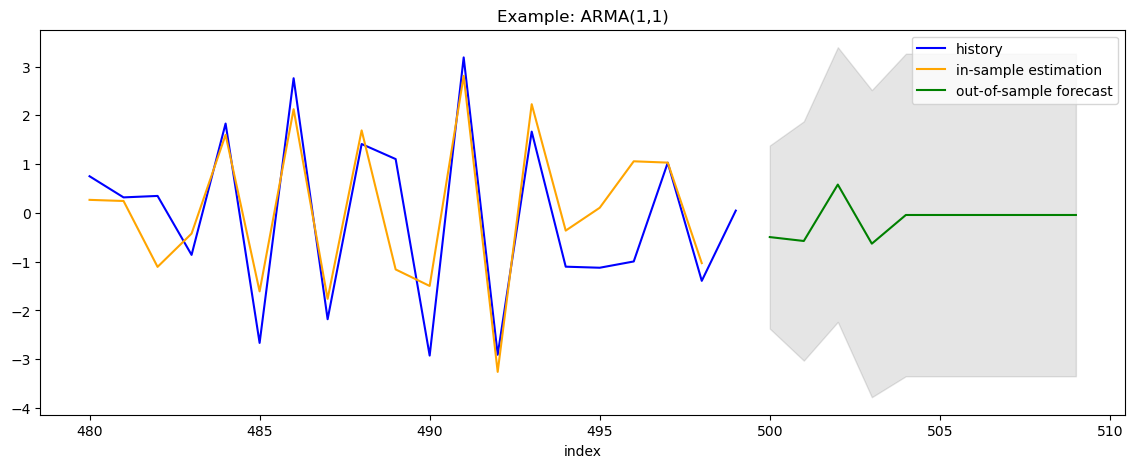

In [19]:
#zoom in and add confidence interval

history_new = history[480:500]
estimation_new = estimation[480:500]
forecast = results.get_forecast(10).summary_frame()
forecast['index']=range(500,510,1)

pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
history_new.plot(kind='line',y='x',color='blue', label='history', ax=ax)
estimation_new.plot(kind='line',y='x',color='orange', label='in-sample estimation', ax=ax)
forecast.plot(kind='line',x='index',y='mean',color='green', label='out-of-sample forecast', ax=ax)
ax.fill_between(forecast['index'], forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Example: ARMA(1,1)')
plt.show()

Practice

Simulate an ARMA(2,2) data of n=500, fit an ARMA(2,2) model, write down the estimated model and plot the forecast for the 10 steps. 

In [21]:
#use a simulated ARMA data
ar = np.array([1, -0.5, 0.3])
ma = np.array([1, 0.2, 0.2])
ARMA_object = ArmaProcess(ar, ma)
simulated_data = ARMA_object.generate_sample(nsample=500)

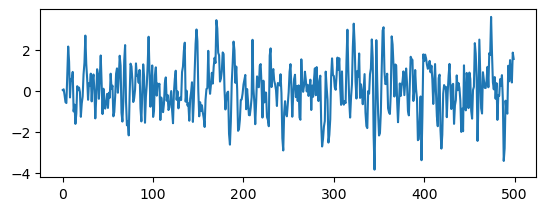

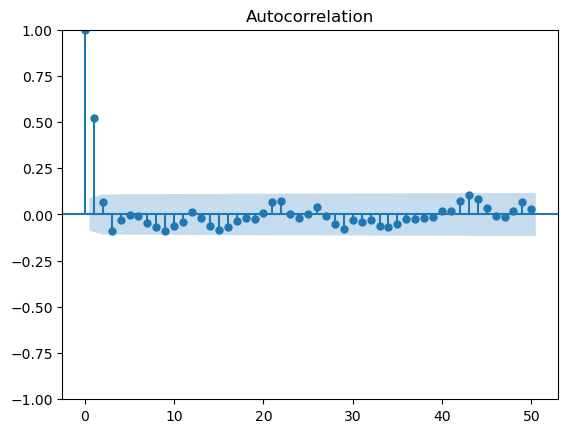

In [22]:
plt.subplot(2,1,1)

plt.plot(simulated_data)
plt.show()

plot_acf(simulated_data,lags=50)
plt.show()

In [25]:
model = ARIMA(simulated_data, order=(2,0,2))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -699.232
Date:                Tue, 07 Nov 2023   AIC                           1410.464
Time:                        13:42:40   BIC                           1435.751
Sample:                             0   HQIC                          1420.387
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0886      0.078      1.143      0.253      -0.063       0.241
ar.L1          0.0463      0.288      0.161      0.872      -0.518       0.610
ar.L2         -0.1525      0.113     -1.348      0.1

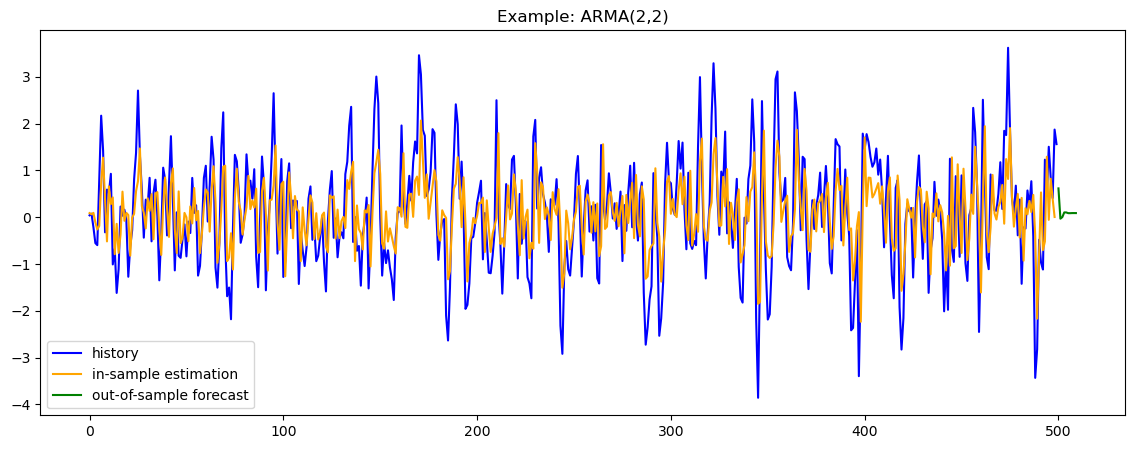

In [28]:
history =  pd.DataFrame(simulated_data)

pred = results.predict(start=0, end=510)
prediction = pd.DataFrame(pred)
estimation = prediction[0:499]
forecast = prediction[500:510]

history.columns =['x']
estimation.columns =['x']
forecast.columns =['x']

pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
history.plot(kind='line',y='x',color='blue', label='history', ax=ax)
estimation.plot(kind='line',y='x',color='orange', label='in-sample estimation', ax=ax)
forecast.plot(kind='line',y='x',color='green', label='out-of-sample forecast', ax=ax)
plt.title('Example: ARMA(2,2)')
plt.show()

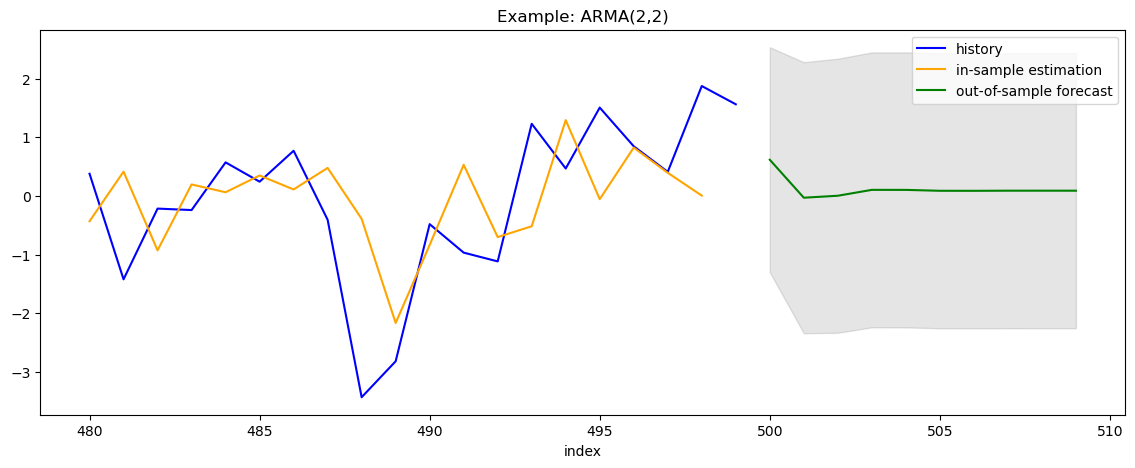

In [30]:
history_new = history[480:500]
estimation_new = estimation[480:500]
forecast = results.get_forecast(10).summary_frame()
forecast['index']=range(500,510,1)

pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
history_new.plot(kind='line',y='x',color='blue', label='history', ax=ax)
estimation_new.plot(kind='line',y='x',color='orange', label='in-sample estimation', ax=ax)
forecast.plot(kind='line',x='index',y='mean',color='green', label='out-of-sample forecast', ax=ax)
ax.fill_between(forecast['index'], forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Example: ARMA(2,2)')
plt.show()